In [ ]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense,Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

fields = ['Test_dataset', 'Classifier', 'F1', 'G-mean', 'Accuracy', 'Precision', 'Recall','ROC_AUC','PR_AUC','Balanced_Accuracy','CWA']
df = pd.read_csv("C:/Ronald/uOttawa/CSI 6900/Metallic-main/Metafeature/features.csv")
dataset_names=list(df['Dataset'])
names=np.unique(dataset_names)
results_df = pd.DataFrame(columns=['Classifier', 'Dataset', 'Metric', 'Value', 'Type'])
scaler = MinMaxScaler()
for j in ['KNN','DT','GNB','SVM','RF','GB','ADA','CAT']:
    for i in names:
        print(i)
        # for metric in ['F1','G-mean','Accuracy','Precision','Recall','AUC-ROC','AUC-PR','BalancedAccuracy','CWA']:
        for metric in ['F1']:
            dataframe = df[df['Dataset'] != i]
            x_test_sample = df[df['Dataset'] == i]
            x_test_selected = x_test_sample[x_test_sample[j] == 1]
            y_test = np.array(x_test_selected[metric])
            x_test = x_test_selected.iloc[:, 1:50]
            x_test_sample=x_test.iloc[:,28:]
            count1=1
            sample_not_present=[]
            for kk in range(0,21):
                sample1=list(x_test_sample.iloc[:,kk])
                if 1 not in sample1:
                    sample_not_present.append(count1)
                count1=count1+1
            selected_dataframe = dataframe[dataframe[j] == 1]
            y_train = np.array(selected_dataframe[metric])
            x_train = selected_dataframe.iloc[:, 1:50]
            xgb = xg.XGBRegressor(objective ='reg:squarederror',colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_depth=3,
                                    min_child_weight=1.5,n_estimators=10000, reg_alpha=0.75, reg_lambda=0.45, subsample=0.6, seed=42)

            nn1 = Sequential()
            nn1.add(Dense(64, activation='relu'))
            nn1.add(Dropout(0.5))
            nn1.add(Dense(64, activation='relu'))
            nn1.add(Dropout(0.5))
            nn1.add(Dense(32, activation='relu'))
            nn1.add(Dropout(0.5))
            nn1.add(Dense(16, activation='relu'))
            nn1.add(Dropout(0.5))
            nn1.add(Dense(1))
            # compile the keras model
            nn1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['MeanSquaredError'])

            nn2 = Sequential()
            nn2.add(Dense(64, activation='relu'))
            nn2.add(BatchNormalization())
            nn2.add(Dropout(0.4))
            nn2.add(Dense(32, activation='relu'))
            nn2.add(BatchNormalization())
            nn2.add(Dropout(0.3))
            nn2.add(Dense(1))
            # compile the keras model
            nn2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['MeanSquaredError'])

            knn = KNeighborsRegressor(n_neighbors=5)
            x_train = np.array(x_train)
            y_train[np.isnan(y_train)] = 0
            xgb.fit(np.array(x_train), y_train)
            knn.fit(np.array(x_train), y_train)

            y_pred_xgb = list(xgb.predict(np.array(x_test)))
            if len(y_pred_xgb) != 21:
                for ii in sample_not_present:
                    y_pred_xgb.insert(int(ii)-1,0)
            y_pred_xgb = pd.DataFrame(y_pred_xgb)

            y_pred_knn = list(knn.predict(np.array(x_test)))
            if len(y_pred_knn) != 21:
                for ii in sample_not_present:
                    y_pred_knn.insert(int(ii)-1,0)
            y_pred_knn = pd.DataFrame(y_pred_knn)

            x_train = scaler.fit_transform(np.array(x_train))
            x_test = scaler.transform(np.array(x_test))
            
            y_pred_nn1 = list(nn1.predict(np.array(x_test)))
            y_preds_nn1=[]
            for item in y_pred_nn1:
                y_preds_nn1.append(item[0])
            if len(y_pred_nn1) != 21:
                for ii in sample_not_present:
                    y_preds_nn1.insert(int(ii)-1,0)
            y_pred_nn1 = pd.DataFrame(y_preds_nn1)

            y_pred_nn2 = list(nn2.predict(np.array(x_test)))
            y_preds_nn2=[]
            for item in y_pred_nn2:
                y_preds_nn2.append(item[0])
            if len(y_pred_nn2) != 21:
                for ii in sample_not_present:
                    y_preds_nn2.insert(int(ii)-1,0)
            y_pred_nn2 = pd.DataFrame(y_preds_nn2)

            y_test=list(y_test)
            if len(y_test)!=21:
                for ij in sample_not_present:
                    y_test.insert(int(ij)-1,0)
            y_test=pd.DataFrame(y_test)

            # For each dataset and algorithm, add true and predicted values ​​to results_df
            algorithms = ['XGBoost', 'KNN', 'NN1', 'NN2']
            predictions = [y_pred_xgb, y_pred_knn, y_pred_nn1, y_pred_nn2]

            for value, value_type in zip([y_test] + predictions, ['Real'] + algorithms):
                temp_df = pd.DataFrame({
                    'Classifier': [j] * len(value),
                    'Dataset': [i] * len(value),
                    'Metric': ['F1'] * len(value),  
                    'Value': value.squeeze().tolist(),
                    'Type': [value_type] * len(value)
                })
                results_df = pd.concat([results_df, temp_df], ignore_index=True)


plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x='Classifier', y='Value', hue='Type')
plt.title('Model Predictions vs. Real F1 Scores')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend(title='Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
results_df

,Classifier,Dataset,Metric,Value,Type
0,KNN,Australian,F1,0.633644,Real
1,KNN,Australian,F1,0.710361,Real
2,KNN,Australian,F1,0.665662,Real
3,KNN,Australian,F1,0.947010,Real
4,KNN,Australian,F1,0.678335,Real
...,...,...,...,...,...
130195,CAT,zoo-3,F1,-0.008378,NN2
130196,CAT,zoo-3,F1,0.025626,NN2
130197,CAT,zoo-3,F1,0.230922,NN2
130198,CAT,zoo-3,F1,0.164511,NN2


In [17]:
results_df1 = results_df.loc[(results_df['Value'] <= 1) & (results_df['Value'] >= -1)]

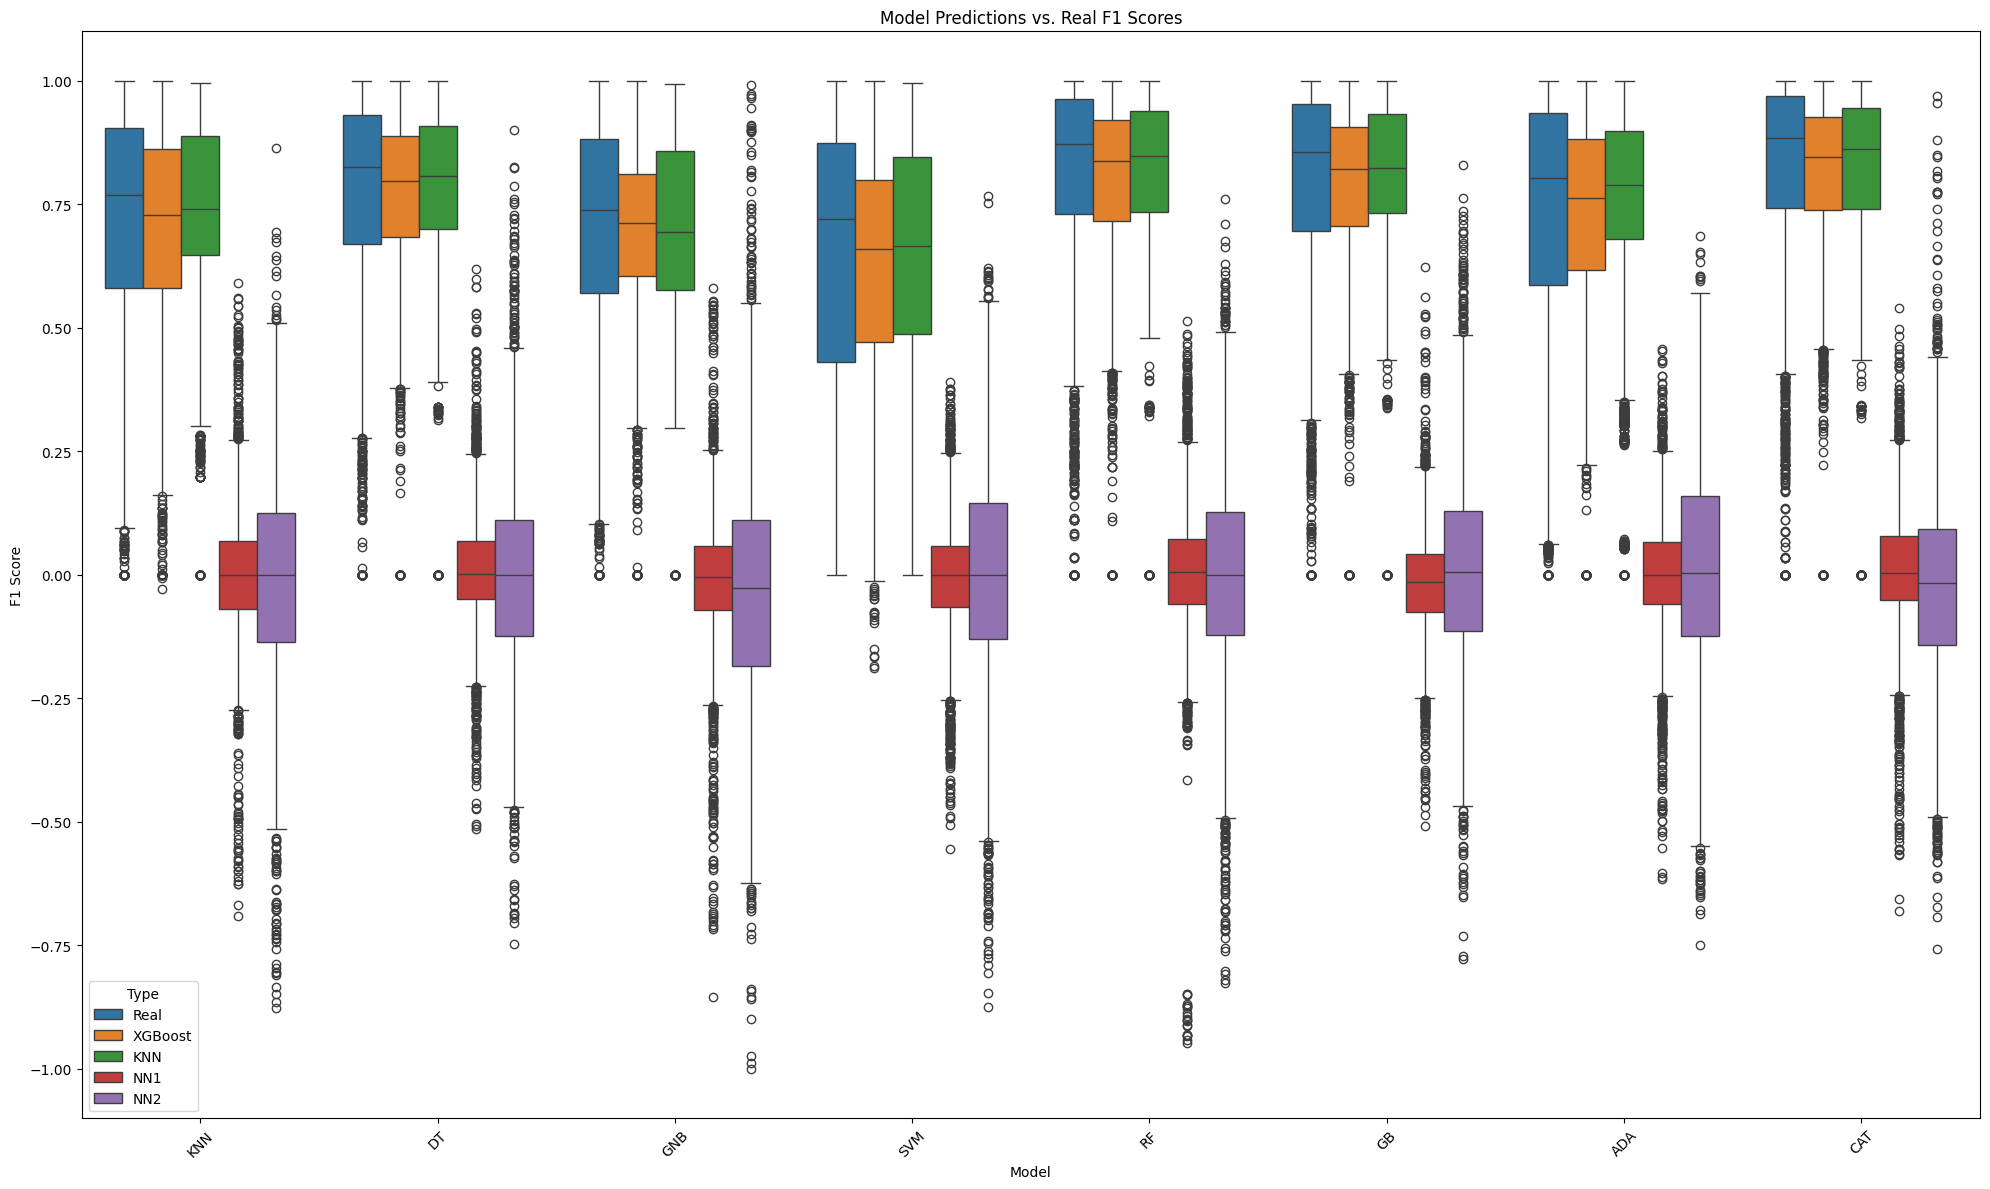

In [18]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=results_df1, x='Classifier', y='Value', hue='Type')
plt.title('Model Predictions vs. Real F1 Scores')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend(title='Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()